In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plt

/home/user/conda/envs/dl/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dir_name = os.getcwd()
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)

Files already downloaded and verified


In [3]:
chan = [[] for _ in range(3)]

for image, label in train_dataset:
    chan[0].append(image[0])
    chan[1].append(image[1])
    chan[2].append(image[2])
    
chan[0] = torch.stack(chan[0])
chan[1] = torch.stack(chan[1])
chan[2] = torch.stack(chan[2])

means = [chan[i].mean().item() for i in range(3)]
stds = [chan[i].std().item() for i in range(3)]
means, stds

([0.4913996756076813, 0.48215845227241516, 0.44653093814849854],
 [0.24703224003314972, 0.24348513782024384, 0.26158785820007324])

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


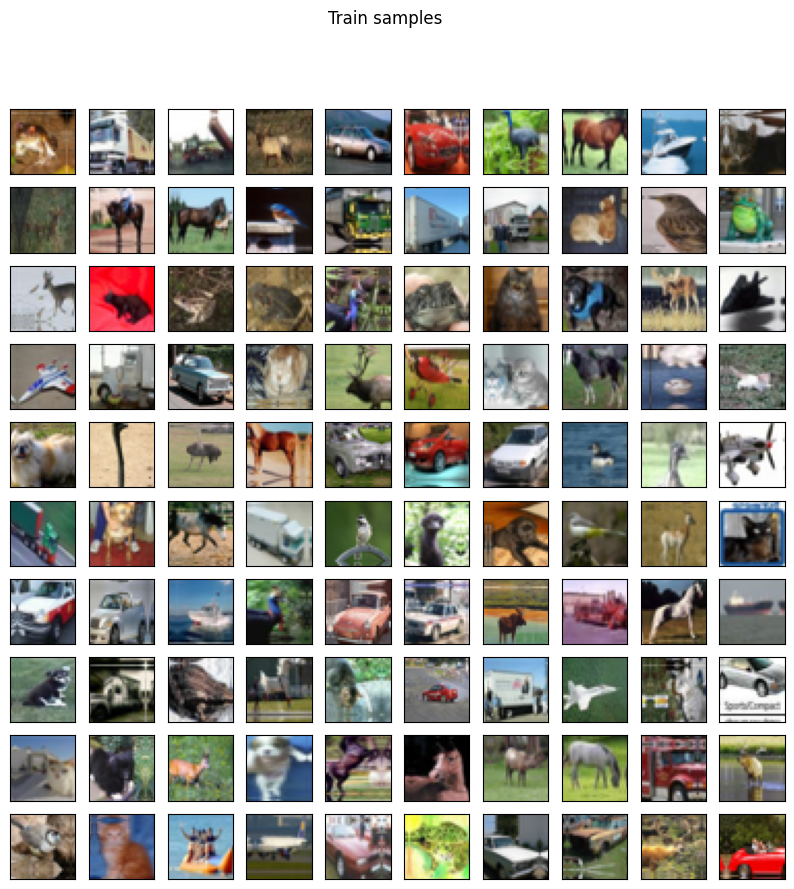

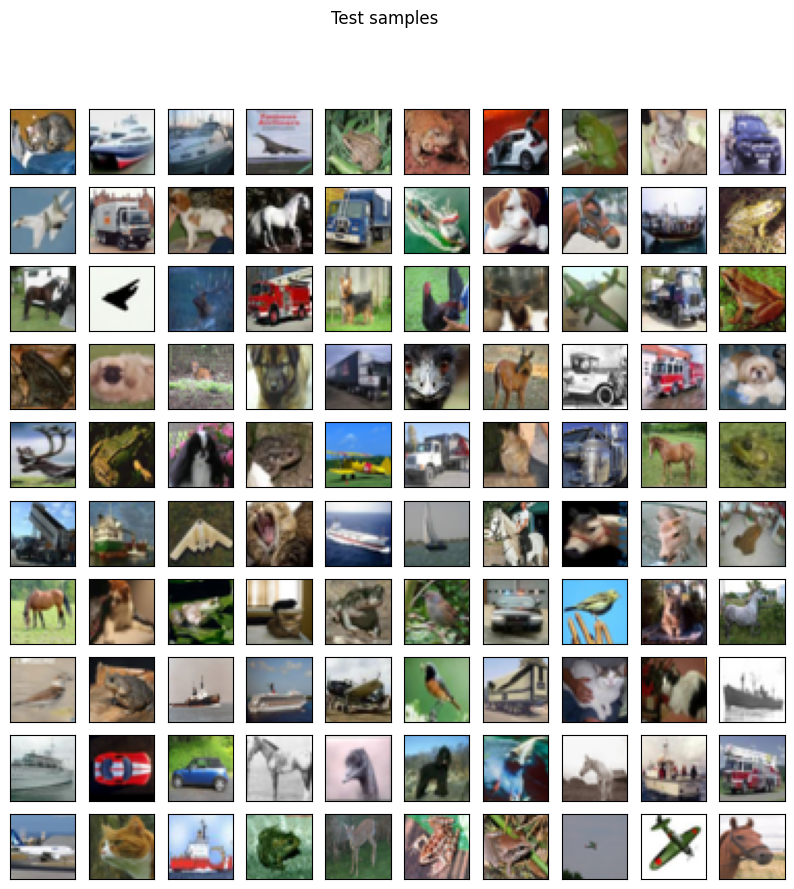

In [4]:
dir_name = os.getcwd()

def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], means, stds).numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap = 'gray')

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds, inplace=True)
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds, inplace=True)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = train_transforms
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = test_transforms
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

In [5]:
from torch.utils.data import random_split

torch.manual_seed(7777)

val_size = 5000
batch_size = 256
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [6]:
full_train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
)
train_data_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
)

In [7]:
from collections import defaultdict
from time import perf_counter

@torch.no_grad()
def get_accuracy(data_loader, model: torch.nn.Module, device):
    tp = 0
    n = 0
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n += labels.size(0)
        tp += (predicted == labels).sum()
    return tp.cpu().item() / n

@torch.no_grad()
def validation_step(dataloader, model, device, loss_func):
    model.eval()
    validation_loss = []
    tp = 0
    sz = 0
    for images, labels in dataloader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        validation_loss.append(loss)
        _, predicted = torch.max(outputs.data, 1)
        tp += (predicted == labels).sum()
        sz += labels.size(0)
        
    mean_loss = torch.stack(validation_loss).mean().cpu().item()
    acc = tp.cpu().item() / sz
    return mean_loss, acc

def fit(
    model, 
    loss_function, 
    optimizer, 
    learning_rate, 
    num_epochs, 
    train_data_loader, 
    val_data_loader, 
    reduce_lr_coef = 1
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = optimizer(model.parameters(), lr=learning_rate)
    history = defaultdict(list)
    train_time = perf_counter()
    
    for epoch in range(num_epochs):
        train_loss = []
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            train_loss.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        history["train_loss"].append(torch.stack(train_loss).mean().cpu().item())
        validation_loss, validation_acc = validation_step(val_data_loader, model, device, loss_function)
        history["val_loss"].append(validation_loss)
        history["val_accuracy"].append(validation_acc)
        
        if (epoch + 1) % 20 == 0:
            learning_rate /= reduce_lr_coef
            for param in opt.param_groups:
                param["lr"] = learning_rate

    train_time = perf_counter() - train_time
    print(f"train time = {train_time}")
    return history

def fit_predict(
    model, 
    loss_function, 
    optimizer, 
    learning_rate, 
    num_epochs, 
    train_data_loader, 
    test_data_loader, 
    reduce_lr_coef = 1
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = optimizer(model.parameters(), lr=learning_rate)
    train_time = perf_counter()
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if (epoch + 1) % 20 == 0:
            learning_rate /= reduce_lr_coef
            for param in opt.param_groups:
                param["lr"] = learning_rate

    train_time = perf_counter() - train_time
    print(f"train time = {train_time}")
    test_time = perf_counter()
    test_acc = get_accuracy(test_data_loader, model, device)
    test_time = perf_counter() - test_time
    print(f"test time = {test_time}")
    return test_acc

In [8]:
def plot_history(history):

    X = range(len(history["train_loss"]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
    
    ax1.plot(X, history["train_loss"], '-bx')
    ax1.plot(X, history["val_loss"], '-rx')
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax1.legend(['Training', 'Validation'])

    ax2.plot(X, history["val_accuracy"], '-rx')
    ax2.set(xlabel="Epoch", ylabel="Accuracy")

    plt.show()

In [9]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        return out

class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(3, 64)
        self.block2 = ResidualBlock(64, 128)
        self.max_pool = torch.nn.MaxPool2d(2)
        
        self.block3 = ResidualBlock(128, 128)
        self.block4 = ResidualBlock(128, 128)
        
        self.block5 = ResidualBlock(128, 256)
        
        self.block6 = ResidualBlock(256, 256)
        self.block7 = ResidualBlock(256, 256)
        
        self.block8 = ResidualBlock(256, 512)
        
        self.block9 = ResidualBlock(512, 512)
        self.block10 = ResidualBlock(512, 512)
        
        self.avg_pool = torch.nn.MaxPool2d(4)
        
        self.linear = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512 * 1 * 1, 10)
        )
        self._init()
        
    def _init(self):
        for param in self.parameters():
            try:
                torch.nn.init.xavier_normal_(param)
            except:
                continue

    def forward(self, x):
        out = self.max_pool(self.block2(self.block1(x)))
        g1 = self.block4(self.block3(out))
        out = g1 + out
        
        out = self.max_pool(self.block5(out))
        g2 = self.block7(self.block6(out))
        out = g2 + out
        
        out = self.max_pool(self.block8(out))
        g3 = self.block10(self.block9(out))
        out = g3 + out
        
        out = self.avg_pool(out)
        out = self.linear(out)
        return out

In [10]:
resnet_history = fit(
    ResNet(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    60,
    train_data_loader,
    val_data_loader,
    3
)

train time = 380.2780263312161


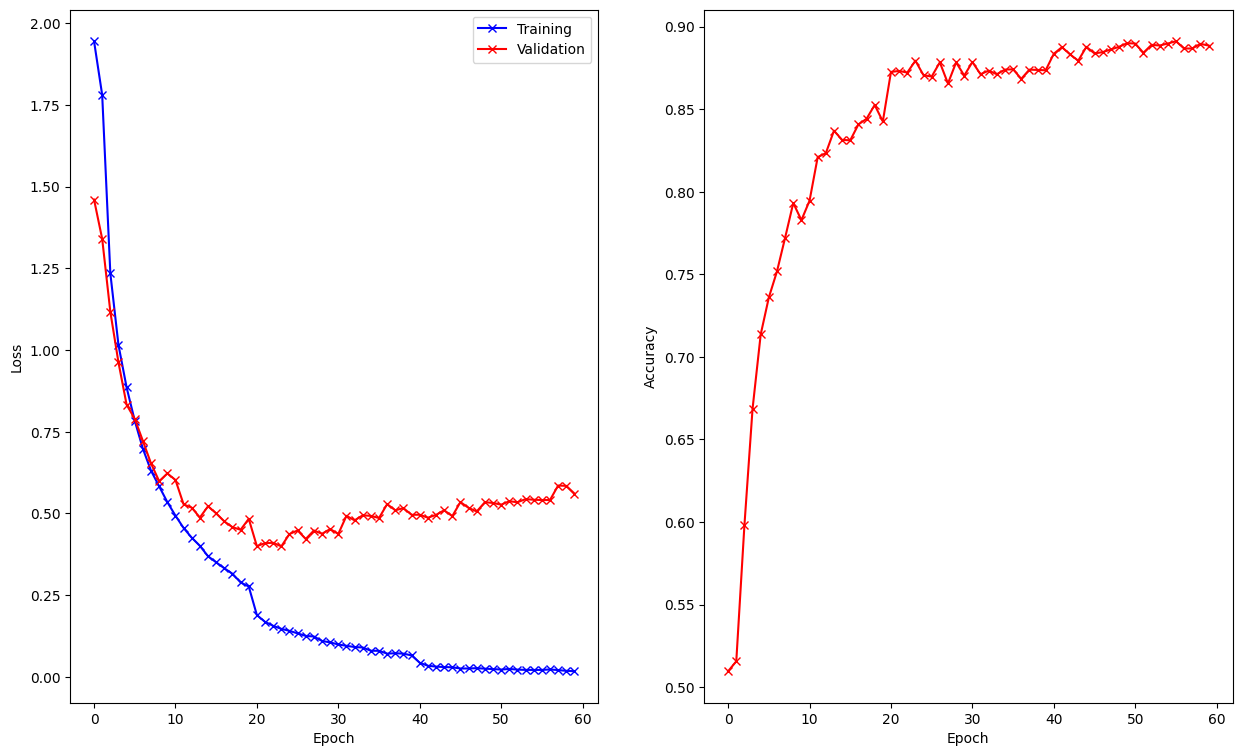

In [11]:
plot_history(resnet_history)

In [12]:
resnet_acc = fit_predict(
    ResNet(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    25,
    full_train_data_loader,
    test_data_loader,
    3
)
print(resnet_acc)

train time = 143.03537660092115
test time = 0.93693021312356
0.9158


In [13]:
class VGG_biggest(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.part1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 32 * 16 * 16
            torch.nn.Dropout(0.2),
            
            torch.nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 64 * 8 * 8
            torch.nn.Dropout(0.25),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 128 * 4 * 4
            torch.nn.Dropout(0.3),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 256 * 2 * 2
            torch.nn.Dropout(0.35),
            
            torch.nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 512 * 1 * 1
            torch.nn.Dropout(0.4),
            
            torch.nn.Flatten(),
            torch.nn.Linear(512 * 1 * 1, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
        ) 
        self._init()
        
    def _init(self):
        for param in self.parameters():
            try:
                torch.nn.init.xavier_normal_(param)
            except:
                continue
        
    def forward(self, x):
        out = self.part1(x)
        return out

In [14]:
vgg_biggest_history = fit(
    VGG_biggest(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    60,
    train_data_loader,
    val_data_loader,
    3
)

train time = 378.62801768630743


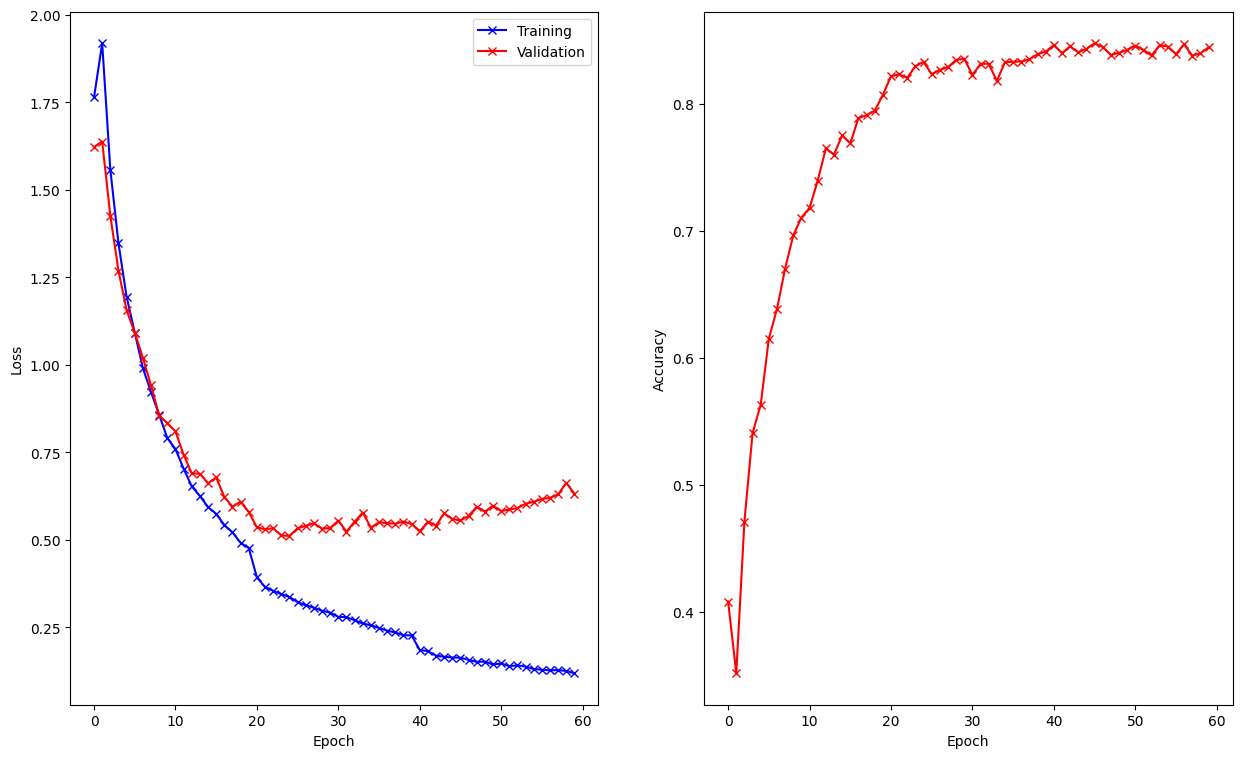

In [15]:
plot_history(vgg_biggest_history)

In [16]:
vgg_biggest_acc = fit_predict(
    VGG_biggest(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    25,
    full_train_data_loader,
    test_data_loader,
    3
)
print(vgg_biggest_acc)

train time = 142.74115718901157
test time = 0.9474588371813297
0.8524


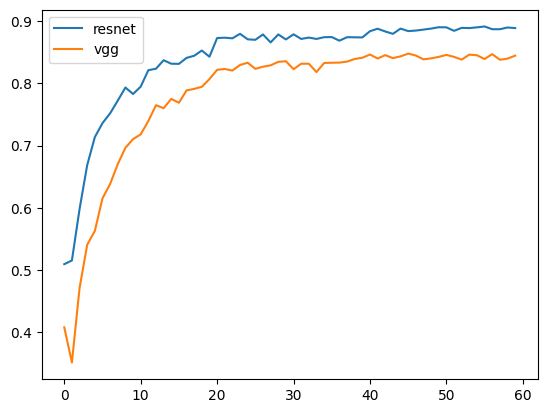

In [18]:
X = range(100)

plt.plot(range(60), resnet_history["val_accuracy"], label="resnet")
plt.plot(range(60), vgg_biggest_history["val_accuracy"], label="vgg")
plt.legend()

plt.show()